# **DataHandlerLSTM**
This class does clean the dataset and get it ready for the LSTM model.

In [1]:
import pandas as pd

class DataHandlerLSTM:

    def __init__(self):
        self.dataset = self.read_data() # read the csv file first
        self.data = self.dataset
        self.handle_date_columns() # generate year and month columns from the data column

        self.data = self.data[['SUBURB', 'YEAR_SOLD', 'MONTH_SOLD', 'PRICE']] # only keep these columns to work on

        self.group_data_by_price() # group every month, year and suburb's mean price
        self.data = self.data.sort_values(by=["YEAR_SOLD", "MONTH_SOLD"]) # sort columns by year and month

        self.generate_suburb_dummies() # generate suburb dummies and append them to the dataset

    def read_data(self):
        return pd.read_csv("/kaggle/input/perth-house-prices/all_perth_310121.csv")

    def print_data(self):
        print(self.data.head())

    def get_data(self):
        return self.data

    def get_og_data(self):
        return self.dataset

    def get_suburbs_dummies(self):
        return list(self.SUBURB_dummies.columns)

    def handle_date_columns(self):
        self.data["DATE_SOLD"] = pd.to_datetime(self.data["DATE_SOLD"])
        self.data['YEAR_SOLD'] = pd.DatetimeIndex(self.data['DATE_SOLD']).year
        self.data['MONTH_SOLD'] = pd.DatetimeIndex(self.data['DATE_SOLD']).month

    def group_data_by_price(self):
        self.data = self.data.groupby(['SUBURB', 'YEAR_SOLD', 'MONTH_SOLD'])['PRICE'].mean().reset_index()

    def generate_suburb_dummies(self):
        self.SUBURB_dummies = pd.get_dummies(self.data["SUBURB"])
        self.data = self.data.drop(["SUBURB"], axis=1)
        self.data = self.data.join(self.SUBURB_dummies)

    def group_by_suburb_price_mean(self):
        data_suburb_mean = self.dataset.groupby(["SUBURB"])["PRICE"].mean()
        return data_suburb_mean

# **ModelPreprocessor**
This class splits the data into two portions, train and test. It reshapes the dataset so we can use it as an input for the model. It also does scale down the dataset to have a faster model.

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

class ModelPreprocessor:

    def __init__(self, data):
        self.data = data
        (self.X_train, self.X_test, self.y_train, self.y_test) = self.split_data_into_train_test() # split the dataset into two portions

        self.scale_down() # scale down X and Y for the model

        # reshape the inputs
        self.X_train = self.reshape_x(self.X_train)
        self.X_test = self.reshape_x(self.X_test)

    def generate_x_y_from_data(self):
        X = self.data.drop(["PRICE"], axis=1)
        y = self.data["PRICE"]
        return (X, y)

    def split_data_into_train_test(self):
        (X, y) = self.generate_x_y_from_data()  # get the model inputs (X) and predicted output (y)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        X_train, y_train = np.array(X_train), np.array(y_train)
        X_test, y_test = np.array(X_test), np.array(y_test)

        # reshape  y
        y_train = self.reshape_y(y_train)
        y_test = self.reshape_y(y_test)

        return (X_train, X_test, y_train, y_test)

    def reshape_y(self, y):
        return np.reshape(y, (y.shape[0], 1))

    def scale_down(self):
        self.scaler = MinMaxScaler()
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.fit_transform(self.X_test)
        self.y_train = self.scaler.fit_transform(self.y_train)
        self.y_test = self.scaler.fit_transform(self.y_test)

    def get_scaler(self):
        return self.scaler

    def reshape_x(self, X):
        return np.reshape(X, (X.shape[0], 1, X.shape[1]))

    def get_processed_data(self):
        return (self.X_train, self.X_test, self.y_train, self.y_test)

# **ModelLSTM**
This class where we create the LSTM model. Also, it calculates the score and saves the model.  

In [3]:
import keras.layers
import matplotlib.pyplot as plt

class ModelLSTM:

    def __init__(self):
        self.model = keras.models.Sequential()

    def create_model(self, X_train, X_test, y_train, y_test):
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

        self.create_layers() # first, we create the model layers
        self.compile_model() # we compile the model
        self.fit_model(50, 10) # fit the model

    def create_layers(self):
        self.model.add(keras.layers.LSTM(50, activation="relu", return_sequences=True, input_shape=(self.X_train.shape[1], self.X_train.shape[2])))
        self.model.add(keras.layers.LSTM(50, activation="relu", return_sequences=False))
        self.model.add(keras.layers.Dense(25))
        self.model.add(keras.layers.Dense(1))

    def compile_model(self):
        self.model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

    def fit_model(self, batch, epochs):
        print("--------------------")
        print("Model epochs: ")
        self.history = self.model.fit(self.X_train, self.y_train, batch_size=batch, epochs=epochs)

    def predict(self, scaler):
        print("--------------------")
        print("Making Predictions: ")
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)

        self.test_predictions = scaler.inverse_transform(self.test_predictions)
        self.train_predictions = scaler.inverse_transform(self.train_predictions)

        self.y_train = scaler.inverse_transform(self.y_train)
        self.y_test = scaler.inverse_transform(self.y_test)

    def evaluate_model(self):
        print("--------------------")
        print("Model scores when passing the test data to the model:")
        print("r-squared (score)   = ", round(self.calc_r2(self.y_test, self.test_predictions) * 100, 3), "%")
        print("mean squared error  = ", self.calc_mean_squared_error(self.y_test, self.test_predictions))
        print("mean absolute error = ", self.calc_mean_absolute_error(self.y_test, self.test_predictions))
        print("mean absolute percentage error = ", round(self.calc_mean_abs_percentage_error(self.y_test, self.test_predictions), 3), "%") 
        
        # Original price vs predicted price plot
        print("--------------------")
        print("Plotting the last 100 observations")
        plt.plot(self.y_test[-99:], label='Original price')
        plt.plot(self.test_predictions[-99:], label='Predicted price')
        plt.legend()
        plt.show()
        print("We get from the plot that the model fits the data very well")
        
    
    def calc_mean_abs_percentage_error(self, y, y_hat):
        sum_of_difference_between_y_y_hat = np.sum(abs((np.array(y) - np.array(y_hat)) / np.array(y)))
        
        return sum_of_difference_between_y_y_hat / len(y) * 100
    
    def calc_mean_squared_error(self, y, y_hat):
        sum_of_difference_between_y_y_hat = np.sum(np.power(np.array(y) - np.array(y_hat), 2))
        
        return sum_of_difference_between_y_y_hat / len(y)
    
    def calc_mean_absolute_error(self, y, y_hat):        
        return np.sum(abs(np.array(y) - np.array(y_hat))) / len(y)
    
    def calc_r2(self, y, y_hat):
        y_mean = np.mean(np.array(y))
        SSR = np.sum(np.power(np.array(y) - np.array(y_hat), 2))
        SST = np.sum(np.power(np.array(y) - y_mean, 2))
        r2 = (1 - (SSR / SST))

        return r2

    def save_model(self):
        model_json = self.model.to_json()
        with open("lstm_model.json", "w") as json_file:
            json_file.write(model_json)
        self.model.save_weights("lstm_model.h5")

# **MakingPredictions**
We use this class to make predictions for the LSTM and linear regression model.

In [4]:
class MakingPredictions:
    def __init__(self, model, suburb_dummies, data):
        self.model = model
        self.suburb_dummies = suburb_dummies
        self.data = data

    def create_prediction_array(self, suburb_index, features_input):
        # merge dummies suburb array with year and month
        prediction_dummies = self.create_suburb_dummies_array(suburb_index)
        prediction_input = np.insert(prediction_dummies, 0, features_input)

        # reshape and scale down
        prediction_input = np.reshape(prediction_input, (1, prediction_input.shape[0]))
        prediction_input = self.scale_down(prediction_input)

        # reshape input to predict
        return np.reshape(prediction_input, (1, 1, prediction_input.shape[1]))

    def make_prediction(self, prediction_input):
        prediction = self.model.predict([prediction_input])
        prediction = self.scale_price_up(prediction[0][0])
        return prediction

    def create_suburb_dummies_array(self, suburb_index):
        prediction_dummies = np.zeros((len(self.suburb_dummies),))
        prediction_dummies[suburb_index] = 1
        return prediction_dummies

    def scale_down(self, arr):
        i = 0
        for col in self.data.columns:
            if col != "PRICE":
                arr[0][i] = (arr[0][i] - self.data[col].min()) / (self.data[col].max() - self.data[col].min())
                i += 1

        return arr

    def scale_price_up(self, price):
        return round(price * round(self.data["PRICE"].max() - self.data["PRICE"].min()) + self.data["PRICE"].min())

# **PredictLSTM**
Here's where we load the model, take user input's and predict based on his input. The user inpus three inputs: year, month and suburb. The outputs will be the predicted mean price for the given suburb on the given date.

In [5]:
import keras

class PredictLSTM:

    def __init__(self):
        self.data_handler = DataHandlerLSTM()
        self.data = self.data_handler.get_data()
        self.suburb_dummies = self.data_handler.get_suburbs_dummies()

    def run(self):
        self.load_model() # load saved model

        self.take_user_inputs()

        makingPredictions = MakingPredictions(self.model, self.suburb_dummies, self.data)
        self.suburb_index = self.get_suburb_index()
        prediction_input = makingPredictions.create_prediction_array(self.suburb_index, [self.year_input, self.month_input])

        prediction = makingPredictions.make_prediction(prediction_input)
        print("--------------------")
        print("Predicted price = ", prediction)

    def take_user_inputs(self):
        self.suburb_input = input("Suburb : ")
        if(self.check_for_suburb(self.suburb_input)):
            self.year_input = input("Year : ")
            self.month_input = input("Month : ")
        else:
            self.take_user_inputs()

    def check_for_suburb(self, suburb_input):
        if suburb_input not in self.suburb_dummies:
            print('Invalid suburb !')
            print("1 - Choose from the suburbs list")
            print("2 - Try again")
            suburb_user_choice = int(input("Your choice : "))
            if suburb_user_choice == 1:
                self.show_suburbs_list(self.suburb_dummies)
                self.suburb_input = int(input("Your choice : "))
                self.suburb_index = self.suburb_input - 1
            else:
                return False

        return True
    
    def get_suburb_index(self):
        if (isinstance(self.suburb_input, int)):
            suburb_index = self.suburb_input - 1
        else:
            suburb_index = np.where(np.array(self.suburb_dummies) == self.suburb_input)[0][0]

        return suburb_index


    def show_suburbs_list(self, suburbs):
        for i in range(len(suburbs)):
            print(i+1 , " - " , suburbs[i])

    def load_model(self):
        json_file = open('lstm_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = keras.models.model_from_json(loaded_model_json)
        # load weights into new model
        self.model.load_weights("lstm_model.h5")

# **UpdateDataset**
After runing the model. We get the predicted mean price for each suburb. We calculate the difference between each old house price and the predicted mean price for the suburb. Then, we add this difference to the old price to have an updated dataset that we can do linear regression on to predict prices in meantime or event in the future.

In [6]:
import datetime

class UpdateDataset:

    def __init__(self, model):
        data_handler = DataHandlerLSTM()
        data = data_handler.get_data()
        suburb_dummies = data_handler.get_suburbs_dummies()

        self.makingPredictions = MakingPredictions(model, suburb_dummies, data)

        self.suburbs = self.makingPredictions.suburb_dummies
        og_date = data_handler.get_og_data()
        self.suburb_mean = og_date.groupby(["SUBURB"])["PRICE"].mean()
        self.predictions_list = []

        self.dataHandlerLSTM = DataHandlerLSTM()
        self.dataset = self.dataHandlerLSTM.dataset

    def updateDataset(self):
        print("--------------------")
        print("\-- Updating the dataset --/")

        self.predictions_list = self.get_predicted_mean_price_for_each_suburb() # first we calculate the difference between the predicted price and the old price
        self.merge_dataset_with_diff_in_mean()
        self.add_the_diff_in_mean_to_the_old_price()
        self.dataset = self.dataset.drop(["DIFF_PRICE", "SUBURBS"], axis=1)
        src = "perth-updated-" + str(datetime.datetime.now().year) + "-" + str(datetime.datetime.now().month) + ".csv"
        self.dataset.to_csv(src)

        print("--- Dataset is updated ---")

    def get_predicted_mean_price_for_each_suburb(self):
        # get mean house prices in each suburb in the current time
        now = datetime.datetime.now()
        year = now.year
        month = now.month
        predictions_list = []
        for i in range(len(self.makingPredictions.suburb_dummies)):
            prediction_input = self.makingPredictions.create_prediction_array(i,  [year, month])
            prediction = self.makingPredictions.make_prediction(prediction_input)
            predictions_list.append(prediction)

        return predictions_list

    def get_diff_between_price_and_predicted_price_dataframe(self):
        diff_in_mean = {"SUBURBS": self.suburbs, "DIFF_PRICE": (self.predictions_list - self.suburb_mean)}
        diff_in_mean_df = pd.DataFrame(diff_in_mean).reset_index()
        return diff_in_mean_df

    def merge_dataset_with_diff_in_mean(self):
        diff_in_mean_df = self.get_diff_between_price_and_predicted_price_dataframe()
        self.dataset = pd.merge(self.dataset, diff_in_mean_df, on="SUBURB")

    def add_the_diff_in_mean_to_the_old_price(self):
        self.dataset["PRICE"] = self.dataset["PRICE"] + self.dataset["DIFF_PRICE"]

# **LSTM**
Here we ask the user if he wants to run the model or predict a suburb mean price. After runing the model, we update the dataset.

In [7]:
class LSTM:

    def __init__(self):
        user_choice = self.take_user_choice()
        if(user_choice == 1):
            self.test_model()
        else:
            self.predict()

    def take_user_choice(self):
        print("--------------------")
        print("1 - Test the model")
        print("2 - Predict")
        choice = int(input("Your choice : "))
        return choice

    def test_model(self):
        data = self.handle_data()

        preprocessor = ModelPreprocessor(data)
        (X_train, X_test, y_train, y_test) = preprocessor.get_processed_data()

        self.run_model(X_train, X_test, y_train, y_test, preprocessor)

    def handle_data(self):
        handler = DataHandlerLSTM()
        return handler.get_data()

    def run_model(self, X_train, X_test, y_train, y_test, preprocessor):
        model = ModelLSTM()
        model.create_model(X_train, X_test, y_train, y_test)
        model.predict(preprocessor.get_scaler())
        model.evaluate_model()

        # save the model to use later when predicting
        model.save_model()

        # save updated dataset
        updateDataset = UpdateDataset(model.model)
        updateDataset.updateDataset()



    def predict(self):
        predictor = PredictLSTM()
        predictor.run()

# **DataHandlerLR**
Here we import the updated dataset and get it ready to do linear regression on.

In [23]:
class DataHandlerLR:
    def __init__(self):
        self.dataset = self.read_dataset()
        self.get_data_ready()

        self.selected_features = self.get_selected_features()
        self.features_without_suburbs = self.selected_features
        self.selected_features = self.merge_suburbs_with_selected_features()
        self.dataset = self.dataset[self.selected_features]

    def read_dataset(self):
        year = str(datetime.datetime.now().year)
        month = str(datetime.datetime.now().month)
        src = "perth-updated-" + year + "-" + month + ".csv"
        return pd.read_csv(src)

    def get_data_ready(self):
        # create suburb dummies
        SUBURB_dummies = pd.get_dummies(self.dataset["SUBURB"])
        self.suburbs = list(SUBURB_dummies.columns)
        self.dataset = self.dataset.join(SUBURB_dummies)

        # remove columns
        self.dataset = self.dataset.drop(["ADDRESS", "SUBURB", "NEAREST_SCH", "NEAREST_STN", "DATE_SOLD", "NEAREST_SCH"],axis=1)

    def get_selected_features(self):
        corr_matrix = self.dataset.corr()
        selected_features = corr_matrix[corr_matrix['PRICE'] > 0.2].index.tolist()
        return selected_features

    def get_features_without_suburbs(self):
        return self.features_without_suburbs

    def merge_suburbs_with_selected_features(self):
        return np.insert(self.suburbs, 0, self.selected_features)

    def get_dataset(self):
        return self.dataset

    def get_suburbs_dummies(self):
        return self.suburbs
    
    def save_dataset_metadata(self):
        metadata = pd.DataFrame(columns=self.features_without_suburbs)
        for col in self.dataset[self.features_without_suburbs]:
            metadata[col] = [self.dataset[col].min(), self.dataset[col].max(), self.dataset[col].mean()]

        metadata.to_csv("metadata.csv", index=False)


# **ModelLR**
Here we run the linear regression model.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
import pickle

class ModelLR:

    def __init__(self):
        self.model = LinearRegression()

    def create_model(self, dataset):
        self.dataset = dataset
        self.cv() # fit the model

    def fit_model(self):
        self.X_train = np.reshape(self.X_train, (self.X_train.shape[0], self.X_train.shape[2]))
        self.X_test = np.reshape(self.X_test, (self.X_test.shape[0], self.X_test.shape[2]))
        self.model.fit(self.X_train, self.y_train)

    def predict(self):
        self.train_predictions = self.model.predict(self.X_train)
        self.test_predictions = self.model.predict(self.X_test)

        self.test_predictions = self.scaler.inverse_transform(self.test_predictions)
        self.train_predictions = self.scaler.inverse_transform(self.train_predictions)
        
        self.y_train = self.scaler.inverse_transform(self.y_train)
        self.y_test = self.scaler.inverse_transform(self.y_test)
        
    def cv(self):
        y = self.dataset["PRICE"]
        X = self.dataset.drop(["PRICE"], axis=1)
        X, y = np.array(X), np.array(y)
        
        self.scaler = MinMaxScaler()
        X = self.scaler.fit_transform(X)
        X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

        y = np.reshape(y, (y.shape[0], 1))
        y = self.scaler.fit_transform(y)

        fold_no = 1
        num_folds = 10
        kfold = KFold(n_splits=num_folds, shuffle=True)
        self.acc_per_fold = []

        print("Cross-validation")
        for train, test in kfold.split(X, y):
            print("--------------------")
            print(f'Fold No.{fold_no}')
            self.X_train = X[train]
            self.y_train = y[train]
            self.X_test = X[test]
            self.y_test = y[test]
            estimator = self.fit_model()
            self.predict()
            self.acc_per_fold.append((self.calc_r2(self.y_test, self.test_predictions) * 100))
            
            self.evaluate_model()
            
            if(all(i <= self.acc_per_fold[-1]  for i in self.acc_per_fold)):
                self.save_model()
                print("model is saved.")
            
            fold_no += 1

    def evaluate_model(self):
        print("--------------------")
        print("Plotting the last 100 observations")
        plt.plot(self.y_test[-99:], label='Original price')
        plt.plot(self.test_predictions[-99:], label='Predicted price')
        plt.legend()
        plt.show()
        
        print("score = ", (self.calc_r2(self.y_test, self.test_predictions) * 100))
        print("mean squared error  = ", self.calc_mean_squared_error(self.y_test, self.test_predictions))
        print("mean absolute error = ", self.calc_mean_absolute_error(self.y_test, self.test_predictions))
        print("mean absolute percentage error = ", round(self.calc_mean_abs_percentage_error(self.y_test, self.test_predictions), 3), "%") 
        
    def calc_mean_abs_percentage_error(self, y, y_hat):
        sum_of_difference_between_y_y_hat = np.sum(abs((np.array(y) - np.array(y_hat)) / np.array(y)))
        
        return sum_of_difference_between_y_y_hat / len(y) * 100
    
    def calc_mean_squared_error(self, y, y_hat):
        sum_of_difference_between_y_y_hat = np.sum(np.power(np.array(y) - np.array(y_hat), 2))
        
        return sum_of_difference_between_y_y_hat / len(y)
    
    def calc_mean_absolute_error(self, y, y_hat):        
        return np.sum(abs(np.array(y) - np.array(y_hat))) / len(y)

    def calc_r2(self, y, y_hat):
        y_mean = np.mean(np.array(y))
        SSR = np.sum(np.power(np.array(y) - np.array(y_hat), 2))
        SST = np.sum(np.power(np.array(y) - y_mean, 2))
        r2 = (1 - (SSR / SST))

        return r2

    def save_model(self):
        with open('lr_model.pickle', 'wb') as f:
            pickle.dump(self.model, f)

# **PredictLR**
Here we take the user inputs such as the number of bedrooms or bathrooms. We then load the model and output a prediction.

In [10]:
import pickle

class PredictLR:
    def __init__(self):
        self.dataHandlerLR = DataHandlerLR()
        self.dataset = self.dataHandlerLR.get_dataset()
        self.suburb_dummies = self.dataHandlerLR.get_suburbs_dummies()
        self.take_user_inputs()
        self.load_model()

    def run(self):
        makingPredictions = MakingPredictions(self.model, self.suburb_dummies, self.dataset)
        self.suburb_index = self.get_suburb_index()
        prediction_input = makingPredictions.create_prediction_array(self.suburb_index, self.inputs)

        prediction_input = np.reshape(prediction_input, (prediction_input.shape[2]))

        prediction = makingPredictions.make_prediction(prediction_input)
        print("--------------------")
        print("Predicted price = ", prediction)

    def take_user_inputs(self):
        self.suburb_input = input("Suburb : ")
        if (self.check_for_suburb(self.suburb_input)):
            self.inputs = self.take_features_input()
        else:
            self.take_user_inputs()

    def take_features_input(self):
        inputs = []
        features = self.dataHandlerLR.get_features_without_suburbs()
        features = np.delete(features, 0)
        for feature in features:
            inp = input(feature.capitalize() + ": ")
            inputs.append(inp)
        return inputs

    def check_for_suburb(self, suburb_input):
        if suburb_input not in self.suburb_dummies:
            print('Invalid suburb !')
            print("1 - Choose from the suburbs list")
            print("2 - Try again")
            suburb_user_choice = int(input("Your choice : "))
            if suburb_user_choice == 1:
                self.show_suburbs_list(self.suburb_dummies)
                self.suburb_input = int(input("Your choice : "))
            else:
                return False

        return True

    def show_suburbs_list(self, suburbs):
        for i in range(len(suburbs)):
            print(i + 1, " - ", suburbs[i])
            
    def get_suburb_index(self):
        if (isinstance(self.suburb_input, int)):
            suburb_index = self.suburb_input - 1
        else:
            suburb_index = np.where(np.array(self.suburb_dummies) == self.suburb_input)[0][0]

        return suburb_index

    def load_model(self):
        with open('lr_model.pickle', 'rb') as f:
            self.model = pickle.load(f)

# **LinearReg**
Here we ask the user for his input.

In [17]:
class LinearReg:

    def __init__(self):
        user_choice = self.take_user_choice()
        if(user_choice == 1):
            self.test_model()
        else:
            self.predict()

    def take_user_choice(self):
        print("--------------------")
        print("1 - Test the model")
        print("2 - Estimate")
        choice = int(input("Your choice : "))
        return choice

    def test_model(self):
        dataHandlerLR = DataHandlerLR()
        data = dataHandlerLR.get_dataset()
        self.run_model(data)
        dataHandlerLR.save_dataset_metadata()

    def run_model(self, data):
        model = ModelLR()
        model.create_model(data)

    def predict(self):
        predictLR = PredictLR()
        predictLR.run()

# **App**
This is the main class.

1 - Predict house price (based on date and suburb)
2 - Estimate house price (based on the house features) ** an up-to-date dataset **


Your choice :  1


--------------------
1 - Test the model
2 - Predict


Your choice :  1


--------------------
Model epochs: 
Epoch 1/10
235/235 [==============================] - 4s 5ms/step - loss: 0.0171 - accuracy: 8.5434e-05
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0071 - accuracy: 1.7087e-04
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0069 - accuracy: 1.7087e-04
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0067 - accuracy: 1.7087e-04
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0066 - accuracy: 1.7087e-04
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0066 - accuracy: 1.7087e-04
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0065 - accuracy: 1.7087e-04
Epoch 8/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0064 - accuracy: 1.7087e-04
Epoch 9/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0064 - accuracy: 1.7087e-04
Epoch 10/10
235/235 [=======

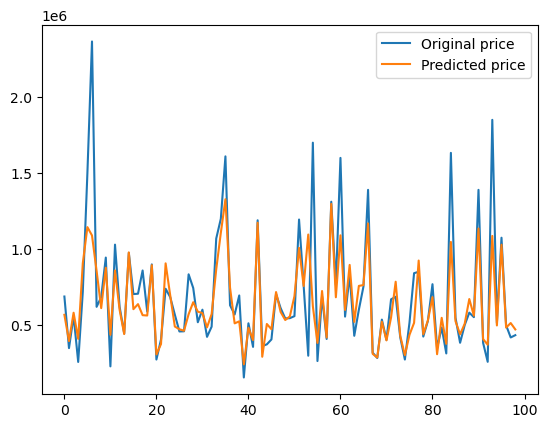

We get from the plot that the model fits the data very well
--------------------
\-- Updating the dataset --/
1/1 [==============================] - 0s 23ms/step
--- Dataset is updated ---


In [12]:
class App:

    def __init__(self):
        user_choice = self.take_user_choice()
        if(user_choice == 1):
            lstm = LSTM()
        else:
            linearReg = LinearReg()

    def take_user_choice(self):
        print("1 - Predict house price (based on date and suburb)")
        print("2 - Estimate house price (based on the house features) ** an up-to-date dataset **")
        choice = int(input("Your choice : "))
        return choice

app = App()

1 - Predict house price (based on date and suburb)
2 - Estimate house price (based on the house features) ** an up-to-date dataset **


Your choice :  2


--------------------
1 - Test the model
2 - Estimate


Your choice :  1


Cross-validation
--------------------
Fold No.1
--------------------
Plotting the last 100 observations


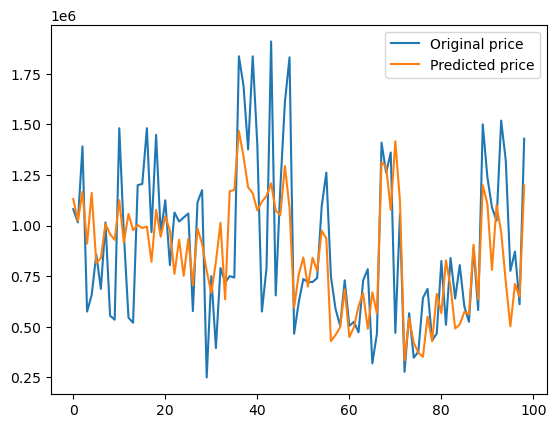

score =  76.87130681623793
mean squared error  =  31997493624.288548
mean absolute error =  112701.44088598719
mean absolute percentage error =  17.341 %
model is saved.
--------------------
Fold No.2
--------------------
Plotting the last 100 observations


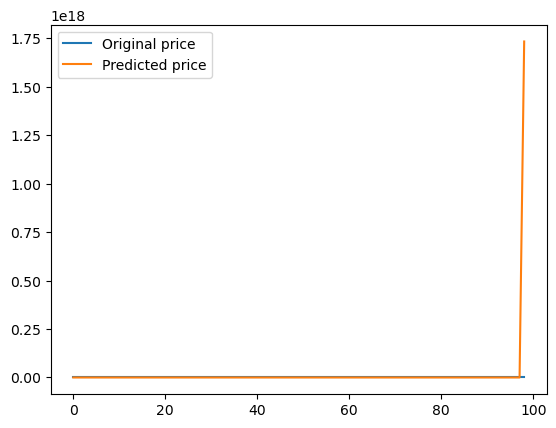

score =  -6.910637272083695e+23
mean squared error  =  8.938469440174579e+32
mean absolute error =  515317064423193.3
mean absolute percentage error =  53763875010.097 %
--------------------
Fold No.3
--------------------
Plotting the last 100 observations


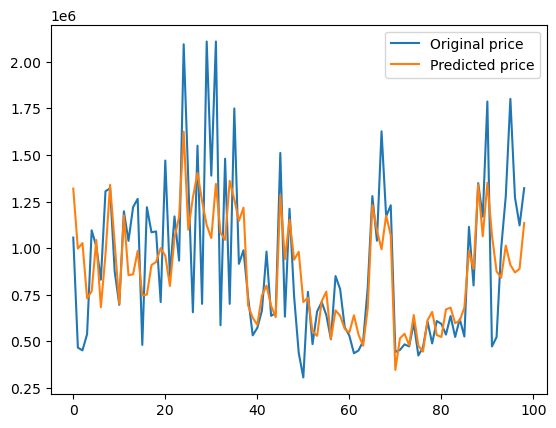

score =  78.10347554377697
mean squared error  =  32186460096.79262
mean absolute error =  111954.07385833877
mean absolute percentage error =  16.39 %
model is saved.
--------------------
Fold No.4
--------------------
Plotting the last 100 observations


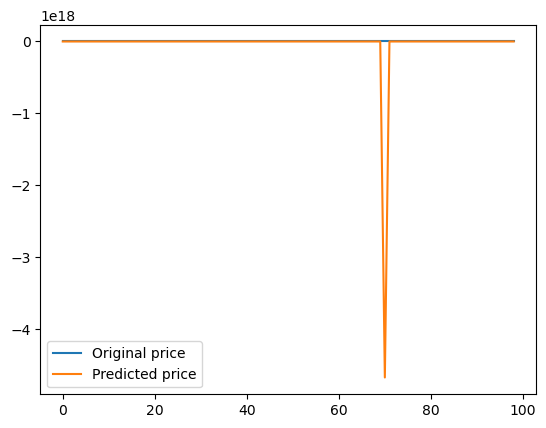

score =  -4.791984411908971e+24
mean squared error  =  6.471498535314186e+33
mean absolute error =  1386581408529200.5
mean absolute percentage error =  171508120158.088 %
--------------------
Fold No.5
--------------------
Plotting the last 100 observations


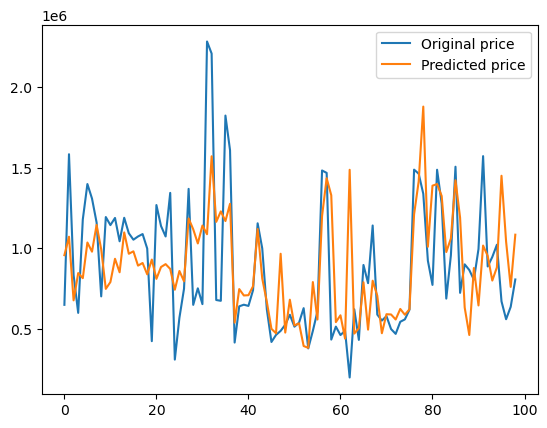

score =  79.24540600386749
mean squared error  =  30322555465.69559
mean absolute error =  109980.12719397161
mean absolute percentage error =  16.39 %
model is saved.
--------------------
Fold No.6
--------------------
Plotting the last 100 observations


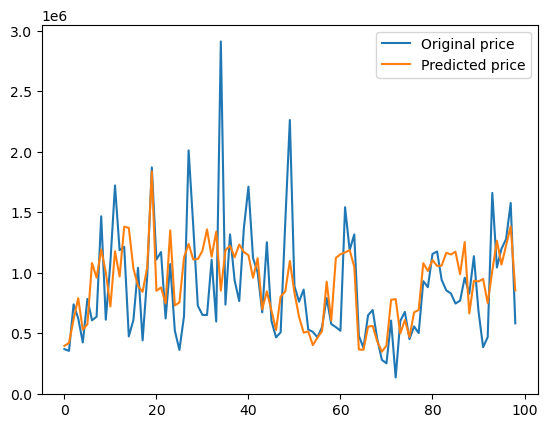

score =  77.75097478566109
mean squared error  =  33577644999.34189
mean absolute error =  114530.58671655571
mean absolute percentage error =  17.346 %
--------------------
Fold No.7
--------------------
Plotting the last 100 observations


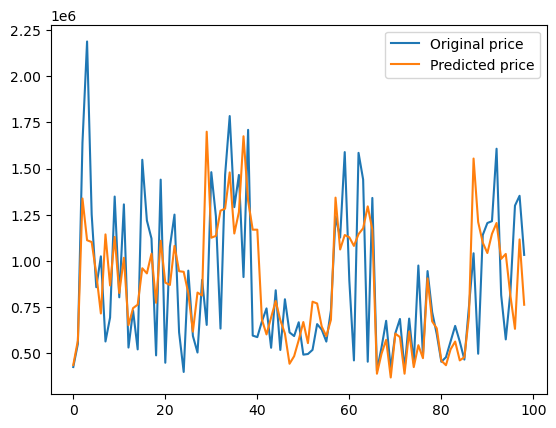

score =  73.80125471128991
mean squared error  =  35900354786.34327
mean absolute error =  115608.69556638943
mean absolute percentage error =  17.956 %
--------------------
Fold No.8
--------------------
Plotting the last 100 observations


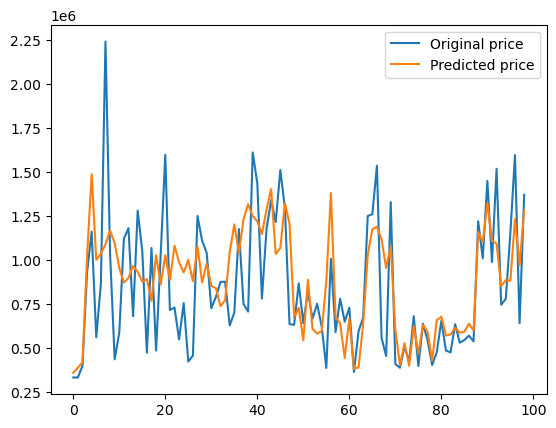

score =  79.05263974336616
mean squared error  =  29232801527.83892
mean absolute error =  109208.78622188156
mean absolute percentage error =  16.97 %
--------------------
Fold No.9
--------------------
Plotting the last 100 observations


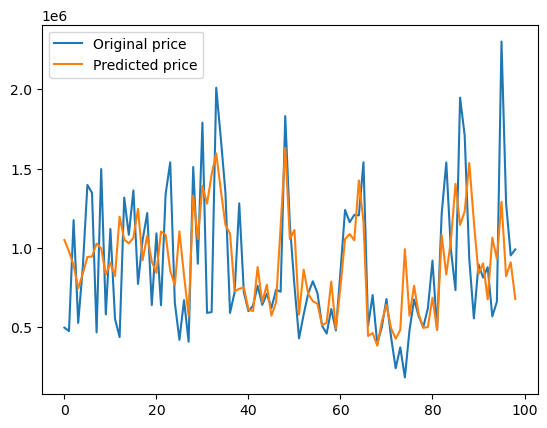

score =  77.74082037149346
mean squared error  =  31801083771.1396
mean absolute error =  111577.30728558869
mean absolute percentage error =  16.641 %
--------------------
Fold No.10
--------------------
Plotting the last 100 observations


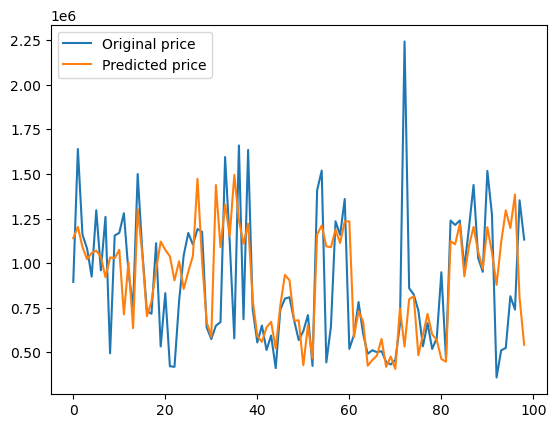

score =  76.54048349224463
mean squared error  =  30992093475.687176
mean absolute error =  107358.6391546722
mean absolute percentage error =  17.304 %


In [13]:
app = App()

1 - Predict house price (based on date and suburb)
2 - Estimate house price (based on the house features) ** an up-to-date dataset **


Your choice :  2


--------------------
1 - Test the model
2 - Estimate


Your choice :  1


Cross-validation
--------------------
Fold No.1
--------------------
Plotting the last 100 observations


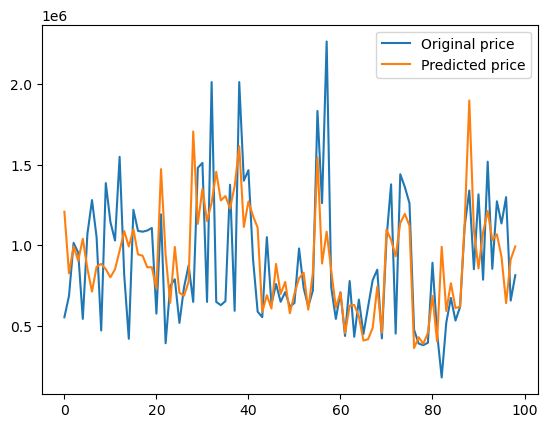

score =  75.58827101346573
mean squared error  =  35257406729.687546
mean absolute error =  113927.37000617689
mean absolute percentage error =  16.898 %
model is saved.
--------------------
Fold No.2
--------------------
Plotting the last 100 observations


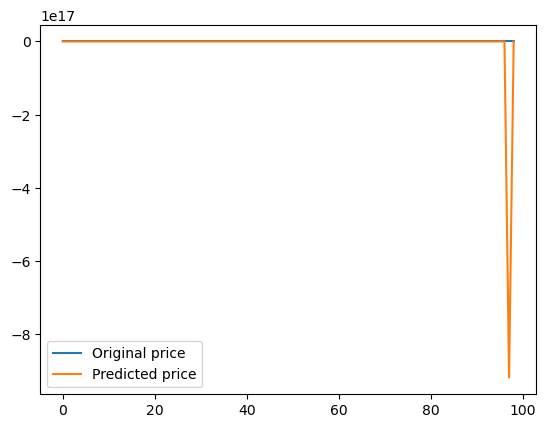

score =  -1.756110498019786e+23
mean squared error  =  2.5113410146201468e+32
mean absolute error =  273146593786874.97
mean absolute percentage error =  28497832389.261 %
--------------------
Fold No.3
--------------------
Plotting the last 100 observations


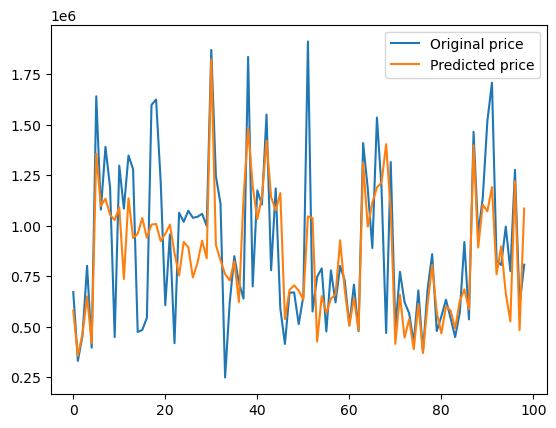

score =  78.84593962263222
mean squared error  =  29429732232.7378
mean absolute error =  107488.24490735766
mean absolute percentage error =  16.51 %
model is saved.
--------------------
Fold No.4
--------------------
Plotting the last 100 observations


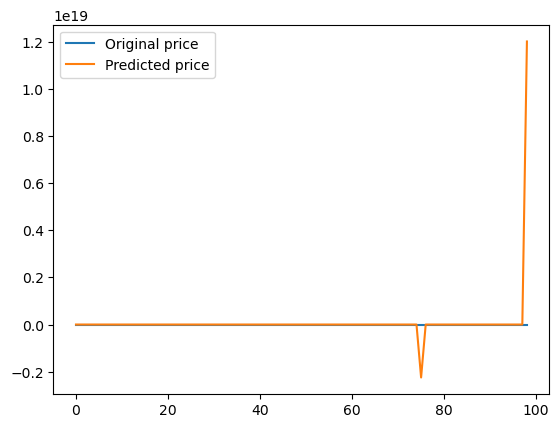

score =  -3.243228292599223e+25
mean squared error  =  4.442248146620259e+34
mean absolute error =  4238765723883413.0
mean absolute percentage error =  429130476360.165 %
--------------------
Fold No.5
--------------------
Plotting the last 100 observations


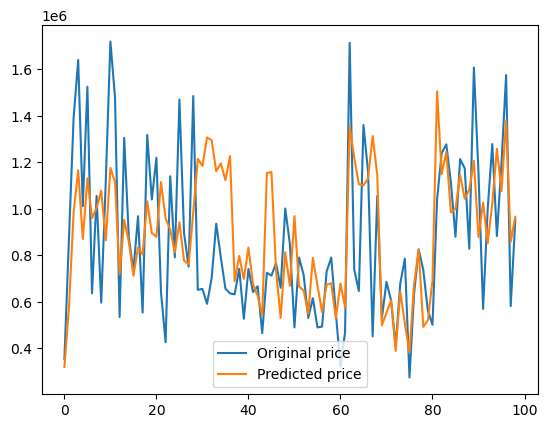

score =  77.3857075098847
mean squared error  =  30397113896.63991
mean absolute error =  109735.97006980171
mean absolute percentage error =  16.778 %
--------------------
Fold No.6
--------------------
Plotting the last 100 observations


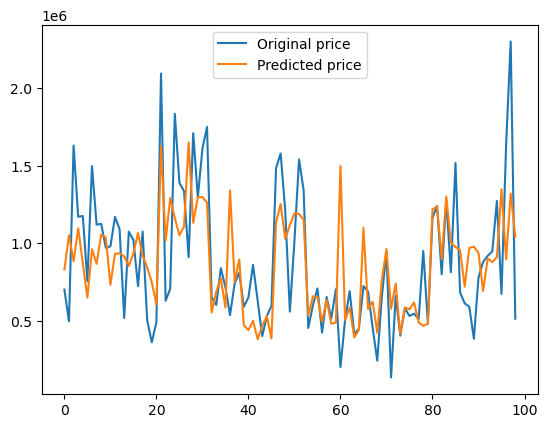

score =  76.79519982498813
mean squared error  =  31685334989.25623
mean absolute error =  111166.68001701137
mean absolute percentage error =  17.809 %
--------------------
Fold No.7
--------------------
Plotting the last 100 observations


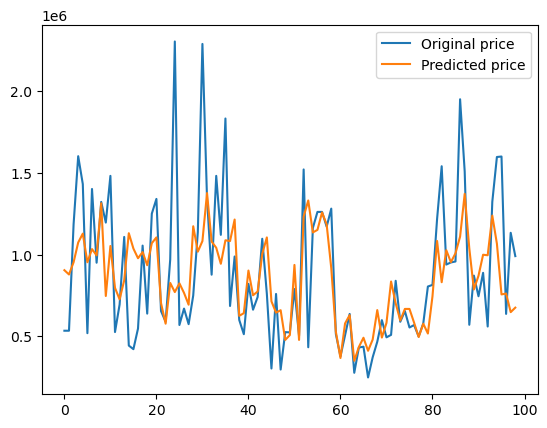

score =  76.9077678907018
mean squared error  =  33408235183.435585
mean absolute error =  111514.57163731431
mean absolute percentage error =  16.556 %
--------------------
Fold No.8
--------------------
Plotting the last 100 observations


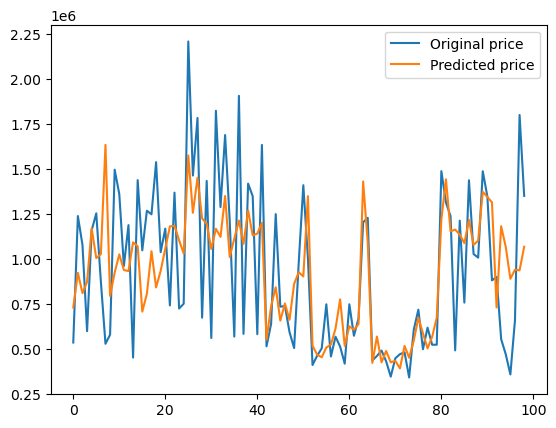

score =  78.68117866928864
mean squared error  =  31453571446.81201
mean absolute error =  112699.01943824383
mean absolute percentage error =  16.815 %
--------------------
Fold No.9
--------------------
Plotting the last 100 observations


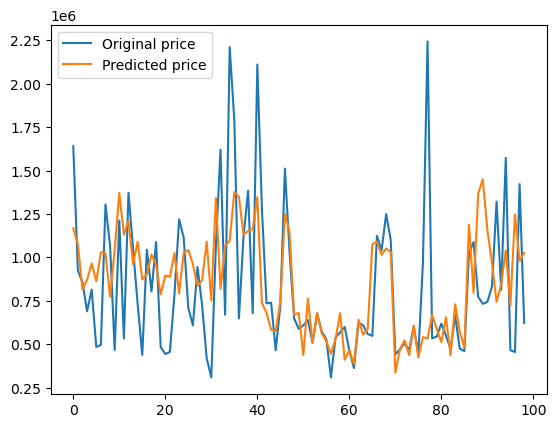

score =  75.11382793441356
mean squared error  =  33027657168.4867
mean absolute error =  113288.37632371737
mean absolute percentage error =  17.689 %
--------------------
Fold No.10
--------------------
Plotting the last 100 observations


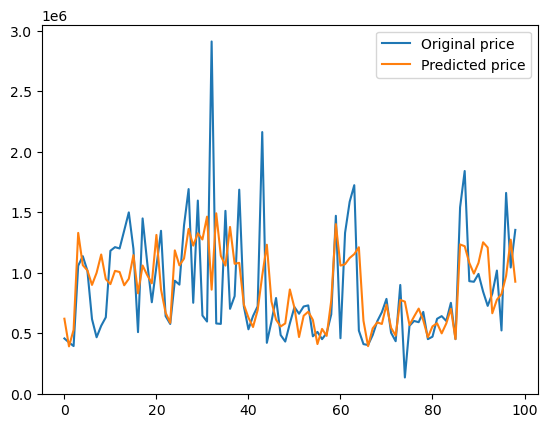

score =  75.81332623073942
mean squared error  =  33716579609.042767
mean absolute error =  111662.5939703058
mean absolute percentage error =  16.83 %


In [24]:
app = App()

In [ ]:
app = App()